# Portfolio Optimization

This [IPython notebook](http://ipython.org/notebook.html) demonstrates the formulation and solution of ???? using GLPK/Mathprog.

J.C. Kantor (Kantor.1@nd.edu)

The latest version of this IPython notebook is available at [http://github.com/jckantor/CBE20255](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

## Initializations

### Install cvxpy and pandas-datareader

This notebook uses two python libraries that are not standard parts of typical distributions. [`cvxpy`](http://www.cvxpy.org/en/latest/) is python library for building and solving models using the principles of 'disciplined convex programming' as developed by Prof. Stephen Boyd and his students at Stanford. The `cvxpy` library incorporates various solvers, and it's use greatly simplifies the use of convex programming for portfolio optimization problems.

The other libary is [`pandas-datareader`](http://pandas-datareader.readthedocs.org/en/latest/). Pandas is a widely used library for the manipulation of data sets. The datareader component had previously been part of the Pandas library, but in the future will be distributed separately. Including it here is a bit 'future-proofing' for this notebook.

To install these libraries, try changing the following cell to a code cell and running.

    !pip install cvxpy
    !pip install --upgrade pandas-datareader

### Import libraries

In [203]:
import matplotlib.pyplot as plt
import numpy as np
import random

# data wrangling libraries
import pandas_datareader.data as web
import pandas as pd
import datetime

# library for convex programming
import cvxpy as cvx

%matplotlib inline

## Load Price Data

Here we create several groups of possible trading symbols, and select one for study.

In [204]:
# Companies of the Dow Jones Industrial Average
djia = ['mmm','axp','aapl','ba','cat','cvx','csco','ko','dis','dd',
       'xom','ge','gs','hd','ibm','intc','jnj','jpm','mcd','mrk',
       'msft','nke','pfe','pg','trv','utx','unh','vz','v','wmt']

# Representative ETF's and ETN's from the energy sector
energy = ['oil','uso','uga','uhn','kol','ung']

syms = djia[0:8]
print syms

['mmm', 'axp', 'aapl', 'ba', 'cat', 'cvx', 'csco', 'ko']


Price data is retrieved using the Pandas DataReader function. The first price data set consists of historical data that will be used to design investment portfolios. The second set will be used for simulation and evaluation of resulting portfolios. The use of 'out-of-sample' data for evaluation is standard practice in these types of applications.

In [205]:
t2 = datetime.datetime.now()
t1 = t2 - datetime.timedelta(365)
t0 = t1 - datetime.timedelta(2*365)

Prices = pd.DataFrame()
PricesSim = pd.DataFrame()
for s in syms:
    Prices[s] = web.DataReader(s,'yahoo',t0,t1)['Adj Close']
    PricesSim[s] = web.DataReader(s,'yahoo',t1,t2)['Adj Close']

## Plot Price and Returns Data

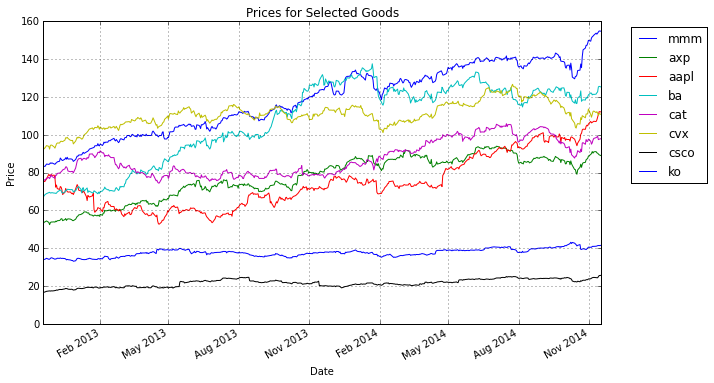

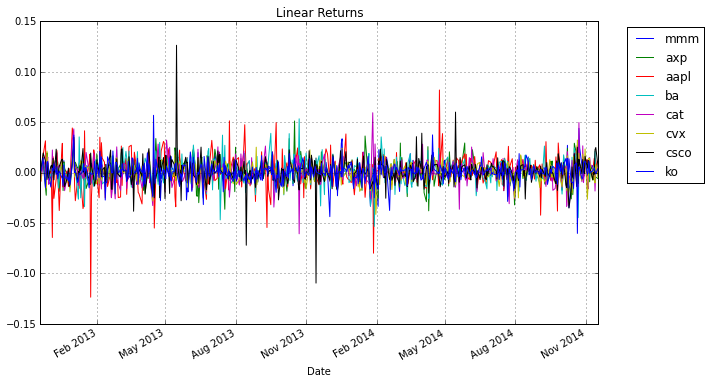

In [206]:
Prices.plot(figsize=(10,6))

plt.title('Prices for Selected Goods')
plt.ylabel('Price')
plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.grid()

Returns = Prices.diff()/Prices.shift(1)

Returns.plot(figsize=(10,6))
plt.title('Linear Returns')
plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.grid()

## Linear and Log Returns

In [207]:
rlin = Returns.mean()
stdev = Returns.std()

rlog = np.log(Prices).diff().mean()

In [208]:
print "Annualized Returns and Standard Deviation\n"
print "Symbol     r_lin       r_log    r_lin-s^2/2    stdev"
for s in Returns.columns.values.tolist():
    print "{0:5s}".format(s),
    print "  {0:9.5f}".format(252.0*rlin[s]),
    print "  {0:9.5f}".format(252.0*rlog[s]), 
    print "  {0:9.5f}".format(252.0*(rlin[s] - 0.5*stdev[s]**2)),
    print "  {0:9.5f}".format(np.sqrt(252.0)*stdev[s])

Annualized Returns and Standard Deviation

Symbol     r_lin       r_log    r_lin-s^2/2    stdev
mmm       0.32126     0.31094     0.31112     0.14242
axp       0.27359     0.25757     0.25766     0.17854
aapl      0.22977     0.19555     0.19593     0.26014
ba        0.33224     0.31223     0.31240     0.19921
cat       0.14128     0.12454     0.12452     0.18308
cvx       0.09611     0.08589     0.08590     0.14286
csco      0.23885     0.21593     0.21594     0.21407
ko        0.11159     0.10028     0.10030     0.15030


## Covariance and Correlation Matrices

In [209]:
sigma = Returns.cov()
rho = sigma.copy()

for i in Returns.columns.values.tolist():
    for j in Returns.columns.values.tolist():
        rho[i][j] = sigma[i][j]/stdev[i]/stdev[j]
        
pd.options.display.float_format = '{:,.6f}'.format

print "\nCovariance Matrix\n"
print sigma

print "\nCorrelation Coefficients\n"
print rho


Covariance Matrix

          mmm      axp     aapl       ba      cat      cvx     csco       ko
mmm  0.000080 0.000057 0.000028 0.000051 0.000051 0.000042 0.000045 0.000028
axp  0.000057 0.000126 0.000034 0.000063 0.000052 0.000050 0.000049 0.000038
aapl 0.000028 0.000034 0.000269 0.000020 0.000042 0.000024 0.000031 0.000011
ba   0.000051 0.000063 0.000020 0.000157 0.000040 0.000037 0.000037 0.000027
cat  0.000051 0.000052 0.000042 0.000040 0.000133 0.000046 0.000046 0.000022
cvx  0.000042 0.000050 0.000024 0.000037 0.000046 0.000081 0.000036 0.000028
csco 0.000045 0.000049 0.000031 0.000037 0.000046 0.000036 0.000182 0.000024
ko   0.000028 0.000038 0.000011 0.000027 0.000022 0.000028 0.000024 0.000090

Correlation Coefficients

          mmm      axp     aapl       ba      cat      cvx     csco       ko
mmm  1.000000 0.568916 0.192314 0.456538 0.488825 0.525333 0.368873 0.326854
axp  0.568916 1.000000 0.183810 0.448086 0.402071 0.495906 0.323703 0.358781
aapl 0.192314 0.183810 1.0000

# Return versus Volatility

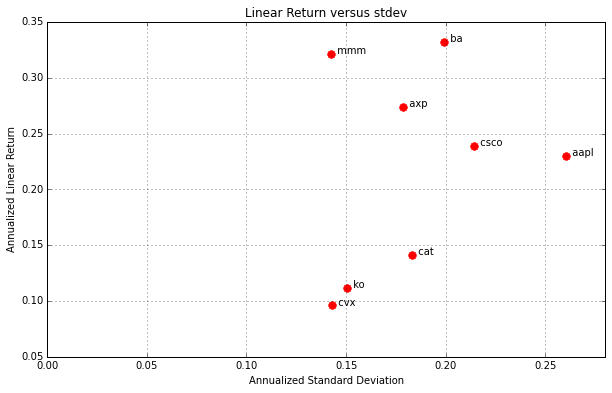

In [210]:
plt.figure(figsize=(10,6))
for s in Returns.columns.values.tolist():
    plt.plot(np.sqrt(252.0)*stdev[s],252*rlin[s],'r.',ms=15)
    plt.text(np.sqrt(252.0)*stdev[s],252*rlin[s],"  {0:5<s}".format(s))

plt.xlim(0.0,plt.xlim()[1])
plt.title('Linear Return versus stdev')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Linear Return')
plt.grid()

## Creating Portfolios

A portfolio is created by allocating current wealth among a collection of assets. Let $w_n$ be the fraction of wealth allocated to the $n^{th}$ asset from a set of $N$ assets. Then

$$\sum_{n=1}^N w_n = 1$$

It may be possible to borrow assets, in which case the corresponding $w_n$ is negative. A _long only_ portfolio is one such that all of weights $w_n$ are greater than or equal to zero.

### Mean Return and Variance of a Portfolio

Denoting the total value of the portfolio as V, the value invested in asset $n$ is $w_nV$. At a price $S_n$, the number of units of the asset is $\frac{w_nV}{S_n}$ for a total value

$$ V = \sum_{n=1}^N \frac{w_n V}{S_n}S_n $$

at the start of the investment period. The value of the investment at the end of the period, $V'$, is given by

$$ V' = \sum_{n=1}^N \frac{w_n V}{S_n}(1+r^{lin}_n)S_n $$

Taking differences we find

$$ V' - V = \sum_{n=1}^N \frac{w_n V}{S_n}r^{lin}_nS_n $$

which, after division, yields the return on the portfolio

$$ r^{lin}_p = \frac{V'-V}{V} = \sum_{n=1}^N w_nr^{lin}_n $$

Taking expectations, the mean return of the portfolio

$$\boxed{\bar{r}^{lin}_{p} = \sum_{n=1}^N w_n \bar{r}^{lin}_n}$$

Variance of portfolio return

$$\boxed{\sigma_{p}^2 = \sum_{m=1}^N\sum_{n=1}^N w_m w_n \sigma_{mn}}$$

## Examples of Portfolios with Two Assets

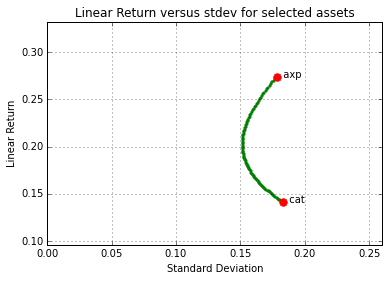

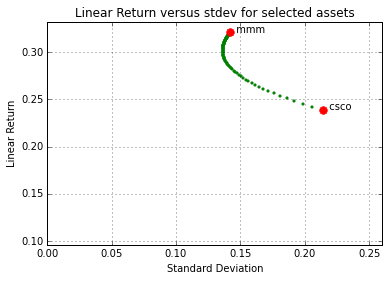

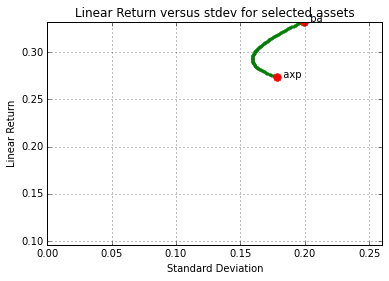

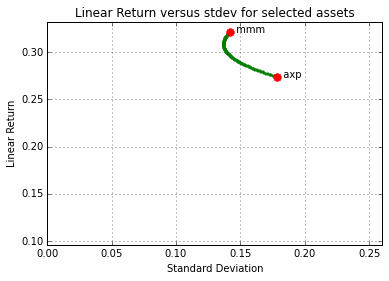

In [211]:
N_examples = 4

for i in range(0,N_examples):
    a,b = random.sample(Prices.columns.values.tolist(),2)

    plt.figure()
    for w in np.linspace(0.0,1.0,100):
        V = w*Prices[a] + (1-w)*Prices[b]
        returnsV = (V.diff()/V.shift(1))
        rV = returnsV.mean()
        sV = returnsV.std()
        plt.plot(np.sqrt(252.0)*sV,252.0*rV,'g.',ms=5)
            
    for s in (a,b):
        plt.plot(np.sqrt(252.0)*stdev[s],252*rlin[s],'r.',ms=15)
        plt.text(np.sqrt(252.0)*stdev[s],252*rlin[s],"  {0:5<s}".format(s))

    plt.xlim(0.0,np.sqrt(252.0)*stdev.max())
    plt.ylim(252.0*rlin.min(),252.0*rlin.max())

    plt.title('Linear Return versus stdev for selected assets')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Linear Return')
    plt.grid()


## Minimum Risk Portfolio

The minimum variance portfolio is found as a solution to 
$$\min_{w_1, w_2, \ldots, w_N} \sum_{m=1}^N\sum_{n=1}^N w_m w_n\sigma_{mn}$$
subject to 
$$\sum_{n=1}^N w_n = 1$$

### cvxpy Model and Solution

In [212]:
N = len(Returns.columns.values.tolist())

w = cvx.Variable(N)
risk = cvx.quad_form(w, np.array(sigma))
prob = cvx.Problem(cvx.Minimize(risk), 
               [cvx.sum_entries(w) == 1])

### Solution

In [213]:
# solution
prob.solve()
print prob.status

optimal


Show weights for individual components of the portfolio

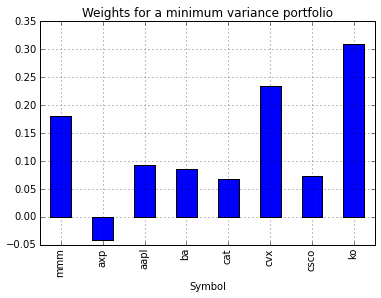

In [214]:
wval = pd.Series(np.array(w.value)[:,0],syms)
wval.plot(kind='bar')

plt.xlabel('Symbol')
plt.title('Weights for a minimum variance portfolio')
plt.grid()

### Out-of-Sample Simulation

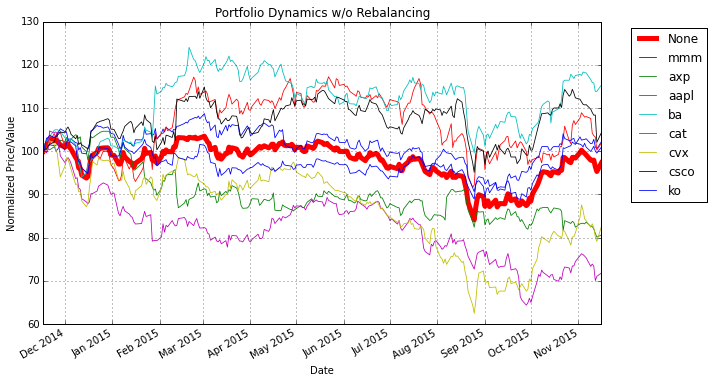

In [238]:
N = len(PricesSim.columns.values.tolist())

V = pd.Series(0,index=PricesSim.index)
for s in PricesSim.columns.values.tolist():
    V += (100.0*float(wval[s])/PricesSim[s][0])*PricesSim[s]
    
V.plot(lw=5,figsize=(10,6),color='red')
plt.hold(True)
for s in PricesSim.columns.values.tolist():
    S = pd.Series(100.0*PricesSim[s]/PricesSim[s][0])
    S.plot(lw=0.8)

plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
plt.title('Portfolio Dynamics w/o Rebalancing')
plt.ylabel('Normalized Price/Value')
plt.grid()

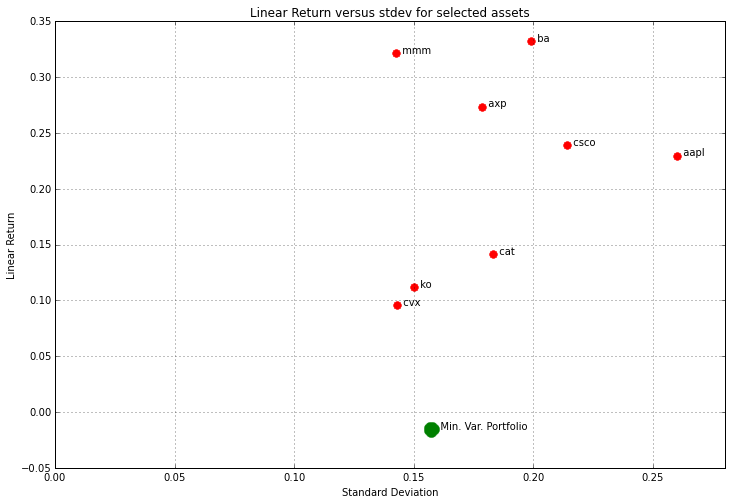

In [239]:
plt.figure(figsize=(12,8))
for s in Returns.columns.values.tolist():
    plt.plot(np.sqrt(252.0)*stdev[s],252*rlin[s],'r.',ms=15)
    plt.text(np.sqrt(252.0)*stdev[s],252*rlin[s],"  {0:5<s}".format(s))

plt.xlim(0.0,plt.xlim()[1])
plt.title('Linear Return versus stdev for selected assets')
plt.xlabel('Standard Deviation')
plt.ylabel('Linear Return')
plt.grid()
plt.hold(True)

ReturnsV = (V.diff()/V.shift(1))
rlinMinVar = ReturnsV.mean()
stdevMinVar = ReturnsV.std()
plt.plot(np.sqrt(252.0)*stdevMinVar,252.0*rlinMinVar,'g.',ms=30)
plt.text(np.sqrt(252.0)*stdevMinVar,252.0*rlinMinVar,'   Min. Var. Portfolio')

## Markowitz Portfolio

The minimum variance portfolio does a good job of handling volatility, but at the expense of relatively low return. The Markowitz portfolio adds an additional constraint to specify mean portfolio return. 
$$\min_{w_1, w_2, \ldots, w_N} \sum_{m=1}^N\sum_{n=1}^N w_m w_n\sigma_{mn}$$
subject to 
$$\sum_{n=1}^N w_n = 1$$
and
$$\sum_{n=1}^N w_n \bar{r}^{lin}_n = \bar{r}^{lin}_p$$
By programming the solution of the optimization problem as a function of $\bar{r}_p$, it is possible to create a risk-return tradeoff curve.

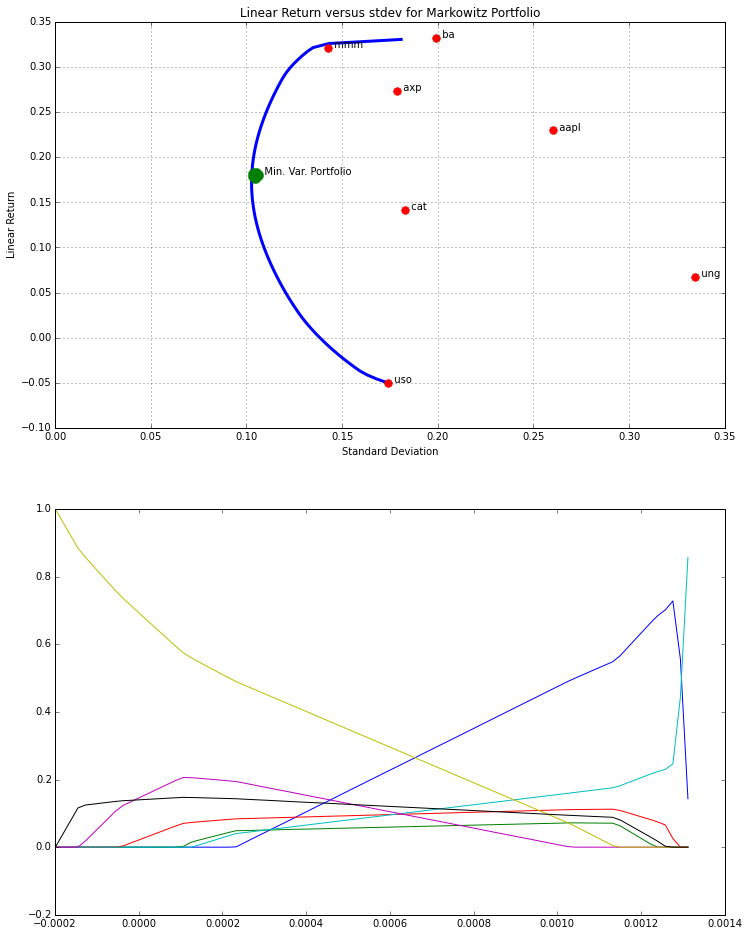

In [159]:
# cvxpy problem description
w = cvx.Variable(N)
r = cvx.Parameter()

risk = cvx.quad_form(w, np.array(sigma))
prob = cvx.Problem(cvx.Minimize(risk), 
               [cvx.sum_entries(w) == 1, 
                np.array(rlin).T*w == r,
               w >= 0])

# lists to store results of parameter scans
r_data = []
stdev_data = []
w_data = []

# scan solution as function of portfolio return
for rp in np.linspace(rlin.min(),1.2*rlin.max(),100):
    r.value = rp
    s = prob.solve()
    if prob.status == "optimal":
        r_data.append(rp)
        stdev_data.append(np.sqrt(prob.solve()))
        w_data.append([u[0,0] for u in w.value])

plt.figure(figsize=(12,16))
plt.subplot(211)

# plot tradeoff curve
plt.plot(np.sqrt(252.0)*np.array(stdev_data), 252.0*np.array(r_data), lw=3)
for s in syms:
    plt.plot(np.sqrt(252.0)*stdev[s],252.0*rlin[s],'r.',ms=15)
    plt.text(np.sqrt(252.0)*stdev[s],252.0*rlin[s],"  {0:5<s}".format(s))

plt.plot(np.sqrt(252.0)*stdevMinVar,252.0*rlinMinVar,'g.',ms=30)
plt.text(np.sqrt(252.0)*stdevMinVar,252.0*rlinMinVar,'   Min. Var. Portfolio')

plt.xlim(0.0,plt.xlim()[1])
plt.title('Linear Return versus stdev for Markowitz Portfolio')
plt.xlabel('Standard Deviation')
plt.ylabel('Linear Return')
plt.grid()


# plot portfolio weights
w_data = np.array(w_data)
plt.subplot(212)
for i in range(N):
    plt.plot(r_data,w_data.T[i])

In [156]:
end = datetime.datetime.now()
start = end - datetime.timedelta(3*365)

PricesSim = pd.DataFrame()
for s in syms:
    PricesSim[s] = web.DataReader(s,'yahoo',start,end)['Adj Close']

In [158]:
    
V = pd.Series((100.0*float(w.value[0])/PricesSim.ix[0,0])*PricesSim.ix[:,0])
for n in range(1,N):
    V += (100.0*float(w.value[n])/PricesSim.ix[0,n])*PricesSim.ix[:,n]

V.plot(lw=5,figsize=(10,6))
plt.hold(True)
for s in PricesSim.columns.values.tolist():
    S = pd.Series(100.0*PricesSim[s]/PricesSim[s][0])
    S.plot(lw=0.5)
V.plot(lw=5,color='red')

plt.title('Portfolio Dynamics w/o Rebalancing')
plt.ylabel('Normalized Price/Value')
plt.grid()

IndentationError: expected an indented block (<ipython-input-158-9774ceb03433>, line 4)

## Risk-Free Asset

The minimum variance portfolio does a good job of handling volatility, but at the expense of relatively low return. The Markowitz portfolio adds an additional constraint to specify mean portfolio return. 
$$\min_{w_1, w_2, \ldots, w_N} \sum_{m=1}^N\sum_{n=1}^N w_m w_n\sigma_{mn}$$
subject to 
$$\sum_{n=1}^N w_n = 1 - w_f$$
and
$$\sum_{n=1}^N w_n \bar{r}^{lin}_n + w_f r_f = \bar{r}^{lin}_p$$
By programming the solution of the optimization problem as a function of $\bar{r}_p$, it is possible to create a risk-return tradeoff curve.

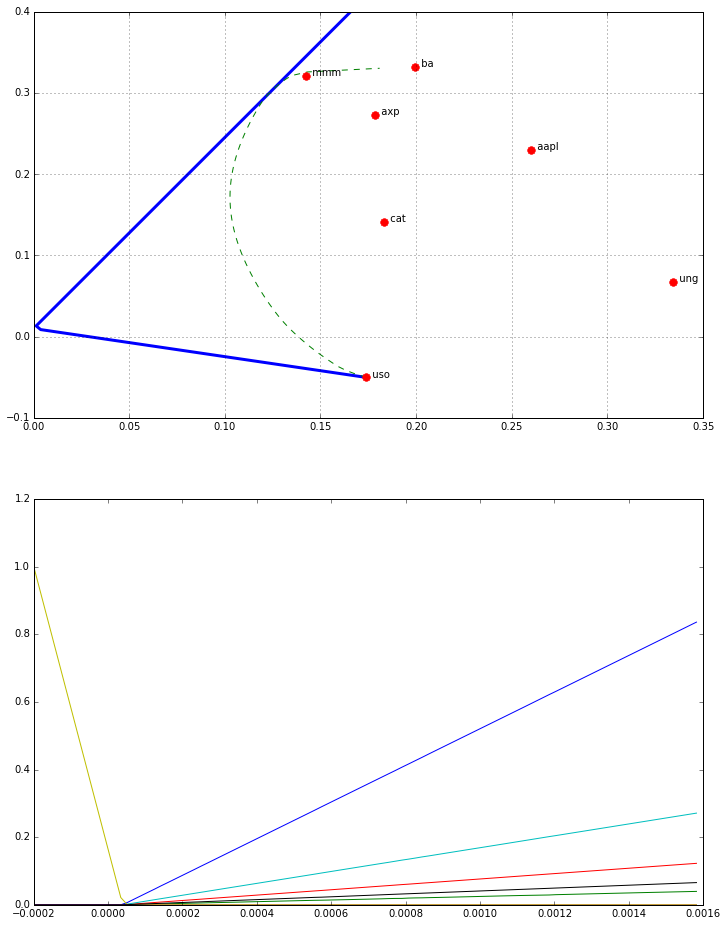

In [161]:
# cvxpy problem description
w = cvx.Variable(N)
wf = cvx.Variable(1)
r = cvx.Parameter()

rf = 0.01/252.0

risk = cvx.quad_form(w, np.array(sigma))
prob = cvx.Problem(cvx.Minimize(risk), 
               [cvx.sum_entries(w) == 1 - wf, 
                np.array(rlin).T*w + wf*rf == r,
               w >= 0])

# lists to store results of parameter scans
r_data_rf = []
stdev_data_rf = []
w_data_rf = []

# scan solution as function of portfolio return
for rp in np.linspace(rlin.min(),1.2*rlin.max(),100):
    r.value = rp
    s = prob.solve()
    if prob.status == "optimal":
        r_data_rf.append(rp)
        stdev_data_rf.append(np.sqrt(prob.solve()))
        w_data_rf.append([u[0,0] for u in w.value])

plt.figure(figsize=(12,16))
plt.subplot(211)
plt.plot(np.sqrt(252.0)*np.array(stdev_data_rf), 252.0*np.array(r_data_rf),lw=3)
plt.plot(np.sqrt(252.0)*np.array(stdev_data), 252.0*np.array(r_data),'g--')
for s in syms:
    plt.plot(np.sqrt(252.0)*stdev[s],252.0*rlin[s],'r.',ms=15)
    plt.text(np.sqrt(252.0)*stdev[s],252.0*rlin[s],"  {0:5<s}".format(s))

plt.xlim(0.0,plt.xlim()[1])
plt.grid()

w_data_rf = np.array(w_data_rf)

plt.subplot(212)
for i in range(N):
    plt.plot(r_data_rf,w_data_rf.T[i])

## Maximum Log Return (to be developed).

optimal


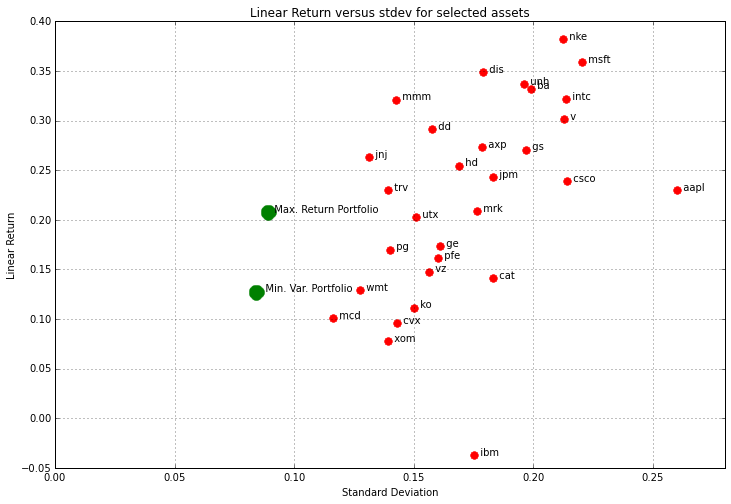

In [68]:
import cvxpy as cvx

N = len(syms)

w = cvx.Variable(N)
risk = cvx.quad_form(w, np.array(sigma))
prob = cvx.Problem(cvx.Maximize(np.array(rlin).T*w-0.5*risk), 
               [cvx.sum_entries(w) == 1,
                risk <= 0.0005/np.sqrt(252.0),
                w>=0])

prob.solve()
print prob.status

plt.figure(figsize=(12,8))
for s in Returns.columns.values.tolist():
    plt.plot(np.sqrt(252.0)*stdev[s],252*rlin[s],'r.',ms=15)
    plt.text(np.sqrt(252.0)*stdev[s],252*rlin[s],"  {0:5<s}".format(s))

plt.xlim(0.0,plt.xlim()[1])
plt.title('Linear Return versus stdev for selected assets')
plt.xlabel('Standard Deviation')
plt.ylabel('Linear Return')
plt.grid()
plt.hold(True)

plt.plot(np.sqrt(252.0)*stdevMinVar,252.0*rlinMinVar,'g.',ms=30)
plt.text(np.sqrt(252.0)*stdevMinVar,252.0*rlinMinVar,'   Min. Var. Portfolio')

wval = np.array(w.value)[:,0].T
rlog = np.dot(np.array(rlin).T,wval)
stdevlog = np.sqrt(np.dot(np.dot(wval,np.array(sigma)),wval))

plt.plot(np.sqrt(252.0)*stdevlog,252.0*rlog,'g.',ms=30)
plt.text(np.sqrt(252.0)*stdevlog,252.0*rlog,'  Max. Return Portfolio')


## Exercises

1. Modify the minimum variance portfolio to be 'long-only', and add a diversification constraints that no more than 20% of the portfolio can be invested in any single asset.  How much does this change the annualized return?  the annualized standard deviation?

2. Modify the Markowitz portfolio to allow long-only positions and a diversification constraint that no more than 20% of the portfolio can be invested in any single asset. What conclusion to you draw?